In [1]:
#!/usr/bin/env python

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from datetime import datetime
from isoweek import Week
from cmdstanpy import CmdStanModel
from cmdstanpy import from_csv
import glob

from numba import njit

In [2]:
# Parse ISO week format (e.g. "2020-W12") into date (Monday of that ISO week)
def iso_week_to_date(iso_str):
    """
    Convert 'YYYY-Www' string into date.
    Example: "2020-W12" -> Monday of the 12th ISO week of 2020.
    """
    match = re.match(r"(\d{4})-W(\d{1,2})", iso_str)
    if not match:
        return None
    year, week = match.groups()
    year, week = int(year), int(week)
    return Week(year, week).monday()

In [3]:
csv_files = glob.glob('stan_output/sinusoid_2025/*20250404104108*.csv') # 
print(csv_files)

fit = from_csv(csv_files)

['stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_3.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_2.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_4.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_1.csv']


In [4]:
# Read the 2010-2025 DK data
df = pd.read_csv("data/DK_2010_2025_posfrac.csv", dtype=str)
df["value"] = pd.to_numeric(df["PosFrac"])

# Create a 'date' column from 'year_Week'
df["date"] = df["year_Week"].apply(iso_week_to_date)
df['date'] = pd.to_datetime(df["date"])

print(df['date'])

0     2010-01-04
1     2010-01-11
2     2010-01-18
3     2010-01-25
4     2010-02-01
         ...    
793   2025-02-24
794   2025-03-03
795   2025-03-10
796   2025-03-17
797   2025-03-24
Name: date, Length: 798, dtype: datetime64[ns]


In [5]:
df_draws = fit.draws_pd()
lp = df_draws["lp__"]  # log posterior column
imax = np.argmax(lp)  # index of sample with highest lp__
best_draw = df_draws.iloc[imax]

In [6]:
import re
import numpy as np

def best_draw_to_dict(row):
    result = {}
    for col in row.index:
        # attempt to match something like "paramName[123]"
        m = re.match(r"(.*)\[(\d+)\]$", col)
        if m:
            base_name = m.group(1)
            idx = int(m.group(2))  # 1-based index from Stan
            val = row[col]

            if base_name not in result:
                result[base_name] = {}
            result[base_name][idx] = val
        else:
            result[col] = row[col]

    for k, v in list(result.items()):
        if isinstance(v, dict):
            max_idx = max(v.keys())
            arr = np.empty(max_idx, dtype=float)
            for i in range(1, max_idx + 1):
                arr[i - 1] = v[i]
            result[k] = arr
    return result

best_draw_dict = best_draw_to_dict(best_draw)


In [7]:
@njit
def SIRS(beta0, dbeta, betaphase, gamma, mu, delta, S0, I0, npieff, noise_level=0.0, continue_npis_for_weeks=0, npi_strength_modulate=1.0, prolong_weeks=0):
    timesteps_per_unit_time = 4
    dt = 1.0/timesteps_per_unit_time
    npieff = np.array([1.0] + list(npieff))
    n_timesteps = (len(npieff) + prolong_weeks) * timesteps_per_unit_time
    npieff_model = np.zeros(n_timesteps)
    for i in range(n_timesteps):
        data_idx = int(np.floor(i/timesteps_per_unit_time))
        if data_idx < len(npieff):
            npieff_model[i] = npieff[data_idx]
        else:
            npieff_model[i] = 1.0
    
    # Modulate NPI strength:
    dnpi = npieff_model - 1.0
    dnpi *= npi_strength_modulate
    npieff_model = np.ones_like(npieff_model) + dnpi
    
    ts = np.linspace(0, len(npieff)+prolong_weeks, n_timesteps)
    # 52 * years
    R0 = 1-I0-S0
    S = np.zeros(n_timesteps)
    I = np.zeros(n_timesteps)
    R = np.zeros(n_timesteps)
    S[0] = S0
    I[0] = I0
    R[0] = R0

    npi_end_time = ts[npieff_model != 1][-1]
    #print("NPIs end at ", npi_end_time)
    mean_npi = np.mean(npieff_model[npieff_model != 1])
    npis = np.zeros(len(ts))

    if noise_level > 0:
        alpha = dt/noise_level**2
        beta = noise_level**2
        k_shape = alpha
        theta_scale = beta
    
    for i in range(1, len(ts)):
        t = ts[i]
        npieff_loc = npieff_model[i]
        if continue_npis_for_weeks < 0:
            if t-npi_end_time >= continue_npis_for_weeks and t-npi_end_time <= 0:
                #print(t, "Pre-terminating NPIs")
                npieff_loc = 1.0
        if continue_npis_for_weeks > 0:
            if t-npi_end_time < continue_npis_for_weeks and t-npi_end_time >= 0:
                #print(t, "Continuing NPIs")
                npieff_loc = mean_npi
        npis[i] = npieff_loc
        beta = npieff_loc * beta0 * (1 + dbeta * np.sin(2 * np.pi * t/52 + betaphase))
        if t > npi_end_time:
            if noise_level > 0:
                DeltaGamma_loc = np.random.gamma(k_shape, theta_scale)
                noise = DeltaGamma_loc/dt
                beta = beta * noise
        foi = beta * I[i-1]
        Sout = (1 - np.exp(-(foi + mu) * dt)) * S[i - 1]
        StoI = foi / (foi + mu) * Sout
        Iout = (1 - np.exp(-(gamma + mu) * dt)) * I[i - 1]
        ItoR = gamma / (gamma + mu) * Iout
        Rout = (1 - np.exp(-(delta + mu) * dt)) * R[i - 1]
        RtoS = Rout * delta/(delta + mu);
        S[i] = S[i - 1] - Sout + mu * dt + RtoS
        I[i] = I[i - 1] + StoI - Iout
        R[i] = R[i - 1] + ItoR - Rout
    return S, I, R, ts, npis

In [8]:
beta0 = best_draw_dict['beta0']
dbeta = best_draw_dict['dbeta']
betaphase = best_draw_dict['betaphase']
gamma = 1/2.5
mu = 1/(80.0 * 52)
delta = best_draw_dict['delta']
S0 = best_draw_dict['S0']
I0 = best_draw_dict['I0']
npieff = best_draw_dict['npieff']

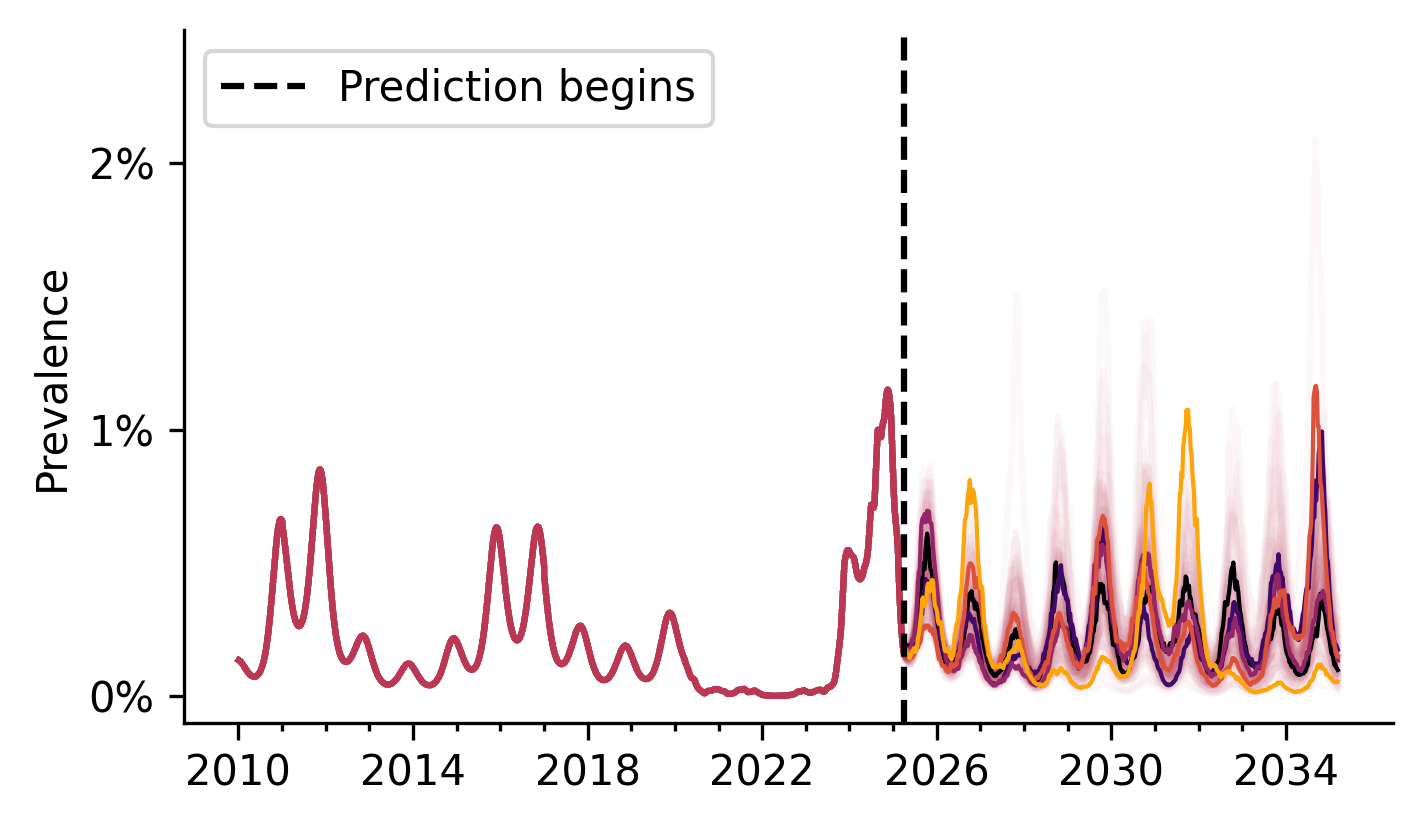

In [9]:
import matplotlib.cm as cm

prolong_weeks = 0

noise_level = 0.15

plt.figure(figsize=(5.2, 3), dpi=300)

n_realizations = 95

continue_npis_for_weeks = 0
for i in range(n_realizations):
    S, I, R, ts, npis = SIRS(beta0, dbeta, betaphase, gamma, mu, delta, S0, I0, npieff, noise_level=noise_level, continue_npis_for_weeks=continue_npis_for_weeks, prolong_weeks=prolong_weeks)
    I_subsampled = I[::4]
    dates_extended = list(df["date"].values)
    last_real_date = dates_extended[-1]
    while len(dates_extended) < len(I_subsampled):
        dates_extended.append(dates_extended[-1] + np.timedelta64(7, 'D'))
    dates_extended = np.array(dates_extended)
    color = plt.cm.inferno(0.5)
    mask = dates_extended > last_real_date
    __ = plt.plot(dates_extended, 100*I_subsampled, alpha=0.03, color=color, linewidth=1.5)

continue_npis_for_weeks = 0
# Individual trajectories:
n_realizations = 5
for i in range(n_realizations):
    S, I, R, ts, npis = SIRS(beta0, dbeta, betaphase, gamma, mu, delta, S0, I0, npieff, noise_level=noise_level, continue_npis_for_weeks=continue_npis_for_weeks, prolong_weeks=prolong_weeks)
    I_subsampled = I[::4]
    dates_extended = list(df["date"].values)
    last_real_date = dates_extended[-1]
    while len(dates_extended) < len(I_subsampled):
        dates_extended.append(dates_extended[-1] + np.timedelta64(7, 'D'))
    dates_extended = np.array(dates_extended)
    mask = dates_extended > last_real_date
    color = plt.cm.inferno(i/n_realizations)
    __ = plt.plot(dates_extended[mask], 100*I_subsampled[mask], alpha=1, color=color, linewidth=1.0)

prediction_start_date = df['date'].values[-1] + np.timedelta64(7, 'D')
ylim_max = 2.5
color = plt.cm.inferno(0.0)
plt.axvline(prediction_start_date, ls="--", color=color, label="Prediction begins")

plt.ylim([-0.1, ylim_max])
plt.yticks([0, 1, 2], labels=['0%','1%','2%'])




#plt.xticks(np.arange(2010, 2040))
xticks = []
xticklabels = []
for i in range(2010, 2035):
    xticks.append(np.datetime64(str(i) + "-01-01"))
    if int(i-2010) % 4 == 0:
        xticklabels.append(str(i))
    else:
        xticklabels.append('')

__ = plt.xticks(xticks, labels=xticklabels)

# Enlarge every nth tick
ax = plt.gca()
n = 4
for i, tick in enumerate(ax.xaxis.get_major_ticks()):
    if i % n == 0:
        tick.tick1line.set_markersize(4)  # Increase tick length
        tick.tick2line.set_markersize(4)
    else:
        tick.tick1line.set_markersize(2)  # Increase tick length
        tick.tick2line.set_markersize(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel("Prevalence")
plt.legend(loc="upper left")